# This notebook is helpful for tracking the training process when train_dupnet.ipynb is running.

In [80]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from test_friend_circles import SDCImageContainer
from sdcdup.utils import create_dataset_from_tiles
from sdcdup.utils import bce

%matplotlib inline
%reload_ext autoreload
%autoreload 2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

ship_dir = "data/input/"
train_image_dir = os.path.join(ship_dir, "train_768")
image_md5hash_grids_file = os.path.join("data", "image_md5hash_grids.pkl")
image_bm0hash_grids_file = os.path.join("data", "image_bm0hash_grids.pkl")
image_cm0hash_grids_file = os.path.join("data", "image_cm0hash_grids.pkl")
image_greycop_grids_file = os.path.join("data", "image_greycop_grids.pkl")
image_entropy_grids_file = os.path.join("data", "image_entropy_grids.pkl")
image_issolid_grids_file = os.path.join("data", "image_issolid_grids.pkl")

In [82]:
def holt_winters_second_order_ewma(x, span, beta):
    # Ref http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/
    N = x.size
    alpha = 2.0 / (1 + span)
    s = np.zeros((N,))
    b = np.zeros((N,))
    s[0] = x[0]
    for i in range(1, N):
        s[i] = alpha * x[i] + (1 - alpha) * (s[i - 1] + b[i - 1])
        b[i] = beta * (s[i] - s[i - 1]) + (1 - beta) * b[i - 1]
    return s


def reversed_recombined_holt_winters(x, span=15, beta=0.3):
    # take EWMA in both directions with a smaller span term
    fwd = holt_winters_second_order_ewma(x, span, beta)
    bwd = holt_winters_second_order_ewma(x[::-1], span, beta)
    c = np.vstack((fwd, bwd[::-1]))  # lump fwd and bwd together
    c = np.mean(c, axis=0)  # average
    return c

In [5]:
sdcic = SDCImageContainer(ship_dir)
sdcic.preprocess_image_properties(
    image_md5hash_grids_file,
    image_bm0hash_grids_file,
    image_cm0hash_grids_file,
    image_greycop_grids_file,
    image_entropy_grids_file,
    image_issolid_grids_file)

full_dataset = create_dataset_from_tiles(sdcic)

100%|██████████| 192555/192555 [00:08<00:00, 23458.57it/s]


In [ ]:
df = pd.read_csv('data/full_SDC_dataset_from_tiles.csv')
full_dataset = list(zip(*[df[c].values.tolist() for c in df]))
print(len(full_dataset))

In [8]:
full_dataset[-1]

keydist(key=('ffffe97f3.jpg', 'ffffe97f3.jpg', 8, 8, 1), dist=0.359375)

In [28]:
n = 5
x = np.arange(n)
ages = np.repeat(x, n).reshape((n, n))
visits = np.tile(x, n).reshape((n, n))

ucb = lambda a, v: 2 * np.sqrt(np.log(a + 1) / (v + 1))
ucb(ages, visits)

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [39]:
ucb(4*1217, 1), ucb(4*1217, 2)

4.1208358026455505

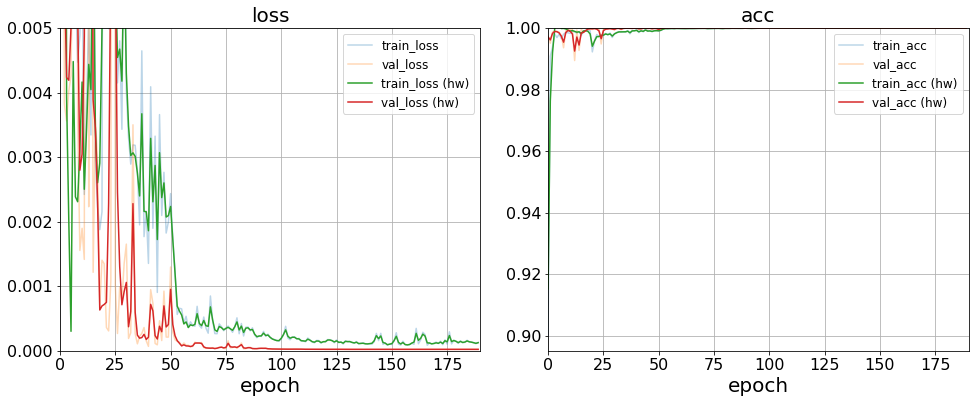

In [213]:
nrows = 1
ncols = 2
fname = 'dup_model.2019_0727_2246.metrics.csv'
fname = 'dup_model.2019_0730_1923.metrics.csv'
fname = 'dup_model.2019_0802_2209.metrics.csv'
df_stats = pd.read_csv('out/' + fname)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6))
# span = 111//30 = 3
# span = epochs // 100
span = 2
field_ylim = {
    'loss': (0, 0.005), 
    'brier_loss': (0, None),
    'focal_loss': (0, None), 
    'focal_loss_1': (0, 5), 
    'focal_loss_2': (0, 5), 
    'dice_coef_loss': (0, None), 
    'soft_dice_loss': (0, None),
    'binary_crossentropy': (0, None),
    'acc': (None, 1), 
    'iou': (None, 1), 
    'mean_iou': (None, 1), 
    'f2': (None, 1), 
    'fbeta': (None, 1), 
    'soft_dice_coef': (None, 1),
    'hard_dice_coef': (None, 1), 
    'hard_dice_coef2': (None, 1), 
    'hard_dice_coef_ch1': (None, 1),
} 
stats_fields = ('loss', 'acc')
filename = []
for j in range(ncols):
    field = stats_fields[j]
#     filename.append(field)

    stats_dict = {
        'train_'+field: df_stats['train_'+field],
        'val_'+field: df_stats['val_'+field],
        'train_'+field+' (hw)': reversed_recombined_holt_winters(np.array(df_stats['train_'+field]), span=span),
        'val_'+field+' (hw)': reversed_recombined_holt_winters(np.array(df_stats['val_'+field]), span=span)
    }
    alphas = {
        'train_'+field: 0.3,
        'val_'+field: 0.3,
        'train_'+field+' (hw)': 1,
        'val_'+field+' (hw)': 1
    }
    ax = axes[j]
    legend_labels = []
    for key, value in stats_dict.items():
        ax.plot(value, alpha=alphas[key])
        legend_labels.append(key)
    # Special case for f2 callback.
    if field == 'fbeta' and 'val_f2' in df_stats:
        ax.plot(df_stats['val_f2'])
        legend_labels.append('val_f2')
    ax.set_title(field)
    ax.set_xlabel(r'epoch')
    ax.set_xlim((0, len(df_stats['epoch'])))
    ax.set_ylim(field_ylim[field])
    ax.grid(True)
    ax.legend(legend_labels)

plt.tight_layout()
# filename = '-'.join(filename)
# plt.savefig(out_dir + filename + '.png')
plt.show()


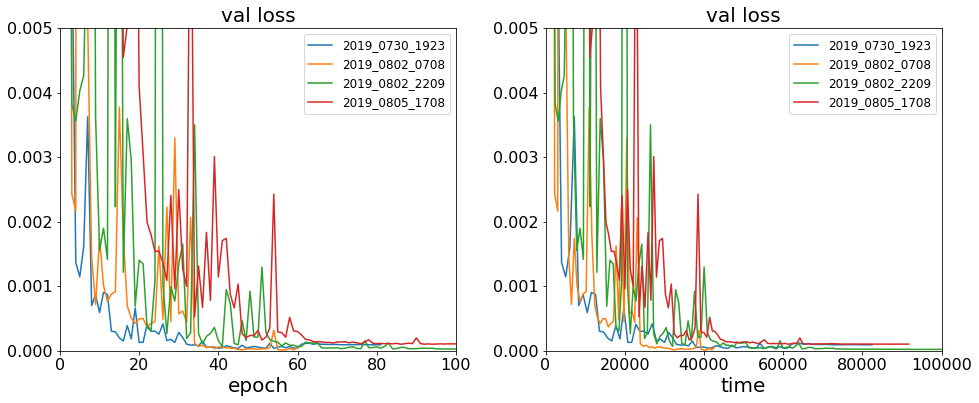

In [224]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6))

ignored_runs = [
    "dup_model.2019_0709_0149.metrics.csv",
    "dup_model.2019_0714_0200.metrics.csv",
    "dup_model.2019_0720_0155.metrics.csv",
    "dup_model.2019_0724_0938.metrics.csv",
    "dup_model.2019_0727_2246.metrics.csv",
#     "dup_model.2019_0730_1923.metrics.csv",
    "dup_model.2019_0731_2310.metrics.csv",
    "dup_model.2019_0801_0954.metrics.csv",
    "dup_model.2019_0801_2010.metrics.csv",
#     "dup_model.2019_0802_0708.metrics.csv",
    "dup_model.2019_0805_0015.metrics.csv",
]
csv_files = []
for fname in os.listdir('out'):
    if fname.endswith('metrics.csv') and fname not in ignored_runs:
        csv_files.append(fname)

legend_labels = []
dataframes = []
for fname in sorted(csv_files):
    dataframes.append(pd.read_csv('out/' + fname))
    legend_labels.append(fname.split('.')[-3])

xlabels = ('epoch', 'time')
xmax = (100, 100000)
for j in range(ncols):
#     xmax = 0
    xlabel = xlabels[j]
    ax = axes[j]
    for df in dataframes:
#         value = df.train_loss
#         ax.plot(df[xlabel], value)
#         value = reversed_recombined_holt_winters(np.array(df.val_loss), span=2)
        value = df.val_loss
        ax.plot(df[xlabel], value)
#         xmax = max(xmax, max(df[xlabel]))

    ax.set_title('val loss')
    ax.set_xlabel(xlabel)
    ax.set_xlim((0, xmax[j]))
    ax.set_ylim((0, 0.005))
#     ax.grid(True)
    ax.legend(legend_labels)

plt.tight_layout()
plt.show()


In [191]:
fname = "dup_model.2019_0802_0708.37.avl.csv"
df_avl = pd.read_csv('out/' + fname)

In [192]:
df_avl.describe()

,ages,visits,losses
count,3.117824e+06,3.117824e+06,3.117824e+06
mean,6.336453e+03,1.847114e+00,1.635506e-05
std,3.713336e+03,6.262924e-01,4.803504e-03
min,1.000000e+00,1.000000e+00,-0.000000e+00
25%,3.115000e+03,2.000000e+00,-0.000000e+00
50%,6.284000e+03,2.000000e+00,-0.000000e+00
75%,9.527000e+03,2.000000e+00,-0.000000e+00
max,1.305600e+04,3.000000e+01,4.107779e+00


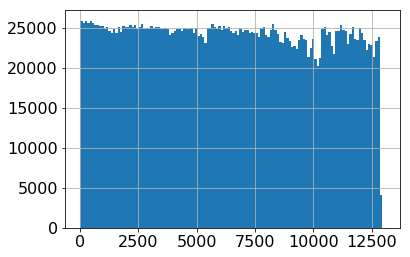

In [193]:
df_avl['ages'].hist(bins=df_avl['ages'].max()//100);

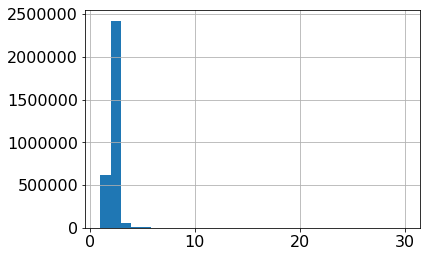

In [194]:
df_avl['visits'].hist(bins=df_avl['visits'].max());

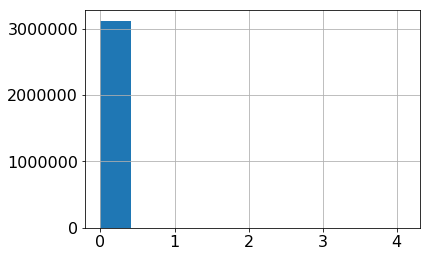

In [195]:
df_avl['losses'].hist();

In [223]:
run_name = "2019_0805_1708"
csv_files = []
for fname in os.listdir('out'):
    if fname.endswith('avl.csv') and run_name in fname:
        csv_files.append(fname)

# dataframes = []
for fname in sorted(csv_files):
    model_name, date_time, epoch, val_loss0, val_loss1, ds_type, file_type = fname.split('.')
    val_loss = '.'.join([val_loss0, val_loss1])
    df = pd.read_csv('out/' + fname)
    print(f"{int(epoch):>2} | {df.ages.max():>5}, ({df.visits.min()}, {df.visits.max():>2}), {df.losses.max():>7.4f}, {df.losses.sum():>12.2f}, {float(val_loss):<8.6f}")
#     dataframes.append((int(epoch), df))

 1 |  1217, (0,  1),  9.8943,   3002842.61, 0.068724
 2 |  2434, (0,  2), 13.3774,   2856264.58, 0.215959
 3 |  3651, (0,  3), 15.2821,   2706100.04, 0.053961
 4 |  4868, (0,  4), 29.4095,   2554754.86, 0.013018
 5 |  6085, (0,  4), 20.8171,   2402341.92, 0.010060
 6 |  7302, (0,  5), 17.3966,   2249949.96, 0.013699
 7 |  8519, (0,  6), 27.6310,   2096892.67, 0.066341
 8 |  9736, (0,  6), 27.6310,   1943687.49, 0.007392
 9 | 10953, (0,  6), 27.6310,   1789657.86, 0.034687
10 | 12170, (0,  6), 11.2106,   1635798.42, 0.007372
11 | 13387, (0,  6), 11.4180,   1483184.47, 0.008713
12 | 14604, (0,  7), 27.6310,   1329158.65, 0.020522
13 | 15821, (0,  8), 27.6310,   1175542.36, 0.014901
14 | 17038, (0,  8), 27.6310,   1021365.13, 0.005148
15 | 18255, (0,  9), 27.6310,    867270.56, 0.011239
16 | 19472, (0,  9), 16.0223,    713339.61, 0.004545
17 | 20689, (0, 10), 20.7301,    558721.82, 0.005038
18 | 21906, (0, 11), 12.6965,    404421.14, 0.009013
19 | 23123, (0, 12), 18.9083,    250266.34, 0.